# Introduction

This notebook presents **lca-algebraic** a small libray above **brightay2**, designed for the definition of **parametric inventories** with fast computation of LCA impacts, suitable for **monte-carlo** analyis.

**lca-algebraic** provides a set of  **helper functions** for : 
* **compact** & **human readable** definition of activites :  
    * search background (tech and biosphere) activities 
    * create new foreground activites with parametrized amounts
    * parametrize / update existing background activities (extending the class **Activity**)
* Definition of parameters
* Computation of LCAs 
* Computation of statistics (including Sobols indices)
* Compute simplified parametric model by fixing minor input parameters

  
# Principles 

The main idea of this libray is to move from **procedural definition** of models (slow and prone to errors) to a **declarative / purely functionnal** definition of parametric models (models as **pure functions**). 

This enables **fast computation of LCA impacts**, useful for Monte Carlo methods and statistical analysis. 
We leverage the **power of symbolic calculus** provided by the library [SymPy](https://www.sympy.org/en/index.html).

We define our model in a **separate database**, as a nested combination of : 
* other foreground activities
* background activities :
    * Technical, refering **ecoinvent DB**
    * Biosphere, refering **brightway2** biosphere activities
    
The **amounts** in exchanges are expressed either as **static amounts**, or **symbolic expressions** of pre-defined **parameters**.

Each activity of our **root model** is defined as a **parametrized combination** of the **foreground activities**, which can themselves be expressed by the **background activities**.

When computing LCA for foreground models, the library develops the model as a combination of **only background activities**. It computes **once for all** the impact of **all required background activities** and compiles a **fast numpy** (vectorial) function for each impact, replacing each background activity by the **static value of the corresponding impact**.

By providing **large vectors** of **parameter values** to those numpy functions, we can compute LCA for **thousands of values** at a time.

![](https://oie-mines-paristech.github.io/lca_algebraic/doc/lca-algebraic.png)


# Compatiblity with brightway2 

Under the hood, the activities we define with **lca-algebraic** are standard **brightway2** activities. 
The amounts of exchanges are stored as **float values** or **serialized as string** in the property **formula**.

Parameters are also stored in the **brightay2** projets, making it fully compatible with **brightway**.

Thus, a model defined with **lca-algebraic** is stored as a regular **bw2** projet. We can use **bw2** native support for [parametrized dataset](https://2.docs.brightway.dev/intro.html#parameterized-datasets) for computing LCAs, even if much more slower than the method explain here.

# Doc

The followng notebook explores the main functions.
Full documentation of the functions is [available here](https://oie-mines-paristech.github.io/lca_algebraic/doc/)

In [110]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import brightway2 as bw

# Custom utils defined for inter-acv
from lca_algebraic import *
from lca_algebraic.stats import * 
import lca_algebraic
from sympy import init_printing, simplify

init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Init brightway2 and databases

In [53]:
# Init the brightway2 project :choose any project name
initDb('MyProject')

# Import Ecoinvent DB (if not already done)
# Update the name and path to the location of the ecoinvent database
importDb("ecoinvent 3.4", './ecoinvent 3.4_cutoff_ecoSpold02/datasets')

# We use a separate DB for defining our foreground model / activities
# Choose any name
USER_DB = 'MyModelName'

# This is better to cleanup the whole foreground model each time, and redefine it in the notebook
# instead of relying on a state or previous run.
# Any persistent state is prone to errors.
resetDb(USER_DB)

# Parameters are stored at project level : reset them also
resetParams(USER_DB)

Biosphere database already present!!! No setup is needed


Database 'ecoinvent 3.4' has already been imported 
Db MyModelName was here. Reseting it


# Introduction to Numpy


Numpy is a python libray for symbolic calculus. 

You write Sympy expression as you write **standard python expressions**, using **sympy symbols** in them. 


The result is then a **symbolic expression that can be manipulated**, instead of a **numeric value**.

In [54]:
from sympy import symbols 

# create sympy symbol
a = symbols("a")

# Expressions are not directly evaluated 
f = a * 2 + 4 
f 

In [57]:
# symbols can be replaced by values afterwards 
f.subs(dict(a=3))

In practice, you don't need to care about Sympy. Just remember that : 
* The parameters defined below are **instances of sympy symbols**
* Any **valid python expression** containing a **sympy symbol** will create a **sympy symbolic expression**

# Define input parameters

First, we define the input parameters of the model together with their distribution.

The numeric parameters are **instances of sympy 'Symbol'**. 

Thus, any python arithmetic expression composed of parameters will result in a **symbolic expression** to be used later in the definition of the model, rather than a static numeric result.

In [58]:
# Example of 'float' parameters
a = newFloatParam(
    'a', 
    default=0.5, min=0, max=2,  distrib=DistributionType.TRIANGLE, # Distribution type, linear by default
    description="hello world")

b = newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    description="foo bar")

share_recycled_aluminium = newFloatParam(
    'share_recycled_aluminium',  
    default=0.6, min=0, max=1, std=0.2, distrib=DistributionType.NORMAL, # Normal distrib, with std dev
    description="Share of reycled aluminium")

# You can define boolean parameters, taking only discrete values 0 or 1
bool_param = newBoolParam(
    'bool_param', 
    default=1)

# Example 'enum' parameter, acting like a switch between several possibilities
# Enum parameters are not Symbol themselves
# They are a facility to represent many boolean parameters at once '<paramName>_<enumValue>' 
# and should be used with the 'newSwitchAct' method 
elec_switch_param = newEnumParam(
    'elec_switch_param', 
    values=["us", "eu"], # If provided as list, all possibilities have te same probability
    default="us", 
    description="Switch on electricty mix")

# Another example enum param
techno_param = newEnumParam(
    'techno_param', 
    values={
        "technoA":0.4, 
        "technoB":0.1,
        "technoC":0.5}, # You can provide a statistical weight for each value, by using a dict
    default="technoA", 
    description="Choice of techonoly")

Param a was already defined : overriding
Param b was already defined : overriding
Param share_recycled_aluminium was already defined : overriding
Param bool_param was already defined : overriding
Param elec_switch_param was already defined : overriding
Param techno_param was already defined : overriding


In [59]:
# List of parameters
list_parameters()

Phase,param,default,min,max,std,distrib,unit
,a,0.5,0,2,,triangle,
,b,0.5,,,,fixed,
,share_recycled_aluminium,0.6,0,1,0.2,normal,
,bool_param,1,0,1,,linear,
,elec_switch_param,us,,,,linear,
,techno_param,technoA,,,,linear,


# Get references to background activities

We provide two functions for easy and fast (indexed) search of activities in reference databases : 
* **findBioAct** : Search activity in **biosphere3** db
* **findTechAct** : Search activity in **ecoinvent** db

Those methods are **faster** and **safer** than using traditionnal "list-comprehension" search : 
They will **fail with an error** if **more than one activity** matches, preventing the model to be based on a random selection of one activity.


In [60]:
# Biosphere activities
ground_occupuation = findBioAct('Occupation, industrial area') # Search by name
heat = findBioAct('Heat, waste', categories=['air']) # Add category selector

# Technosphere activities

# You can add an optionnal location selector
alu = findTechAct("aluminium alloy production, AlMg3", loc="RER")
alu_scrap = findTechAct('aluminium scrap, new, Recycled Content cut-off')

# Elec 
eu_elec = findTechAct("market group for electricity, medium voltage", 'ENTSO-E')
us_elec = findTechAct("market group for electricity, medium voltage", 'US')

# Define the model

The model is defined as a nested combination of background activities with amounts.

Amounts are defined either as constant float values or algebric formulas implying the parameters defined above.

## Create new activities

In [61]:
# Create a new activity
activity1 = newActivity(USER_DB, # We define foreground activities in our own DB
    "first foreground activity", # Name of the activity
    "kg", # Unit
    exchanges= { # We define exhanges as a dictionarry of 'activity : amount'
        ground_occupuation:3 * b, # Amount can be a fixed value 
        heat: b + 0.2  # Amount can be a Sympy expression (any arithmetic expression of Parameters)
    })

# You can create a virtual "switch" activity combining several activities with a switch parameter
elec_mix = newSwitchAct(USER_DB, 
    "elect mix", # Name
    elec_switch_param, # Sith parameter
    { # Dictionnary of enum values / activities
        "us" : us_elec, # By default associated amount is 1
        "eu" : (eu_elec, 0.8)  # You can also provide custom amout or formula with a tuple 
    })

## Copy and update existing activity

You can copy and update an existing background activity.

Several new helper methods have been added to the class **Activity** for easy update of exchanges.

In [62]:
alu2 = copyActivity(
    USER_DB, # The copy of a background activity is done in our own DB, so that we can safely update it                
    alu, # Initial activity : won't be altered
    "Alu2") # New name

# Update exchanges by their name 
alu2.updateExchanges({
    
    # Update amount : the special symbol *old_amount* references the previous amount of this exchange
    "aluminium, cast alloy": old_amount * (1 - share_recycled_aluminium),
    
    # Update input activity. Note also that you can use '*' wildcard in exchange name
    "electricity*": elec_mix,
    
    # Update both input activity and amount. 
    # Note that you can use '#' for specifying the location of exchange (useful for duplicate exchange names)
    "chromium#GLO" : dict(amount=4.0, input=activity1)
}) 

# Add exchanges 
alu2.addExchanges({alu_scrap :  12})

## Final model

Usually, we normalize the final model as the whole LCI divided by the functional value (production of the system)


In [63]:
functional_value = a + 5

model = newActivity(USER_DB, "model", "kg", {
    activity1 : b * 5 + a + 1, # Reference the activity we just created
    alu2: 3 * share_recycled_aluminium, 
    alu:0.4 * a})

normalized_model = newActivity(USER_DB, "normalized model", "kg", {
    model : 1 / functional_value})

## Display activities

**printAct** displays the list of all exchanges of an activity.

Note that symbolic expressions have not been evaluated at this stage

In [64]:
# Print_act displays activities as tables
printAct(activity1) 
printAct(model)
printAct(normalized_model)

first foreground activity (1.000000 kg)  \
                                                                         input   
Heat, waste                          'Heat, waste' (megajoule, None, ('air',))   
Occupation, industrial area  'Occupation, industrial area' (square meter-ye...   

                                                                    
                              amount               unit       type  
Heat, waste                  b + 0.2          megajoule  biosphere  
Occupation, industrial area      3*b  square meter-year  biosphere

model (1.000000 kg)  \
                                                                                   input   
Alu2#RER {user-db}                                          'Alu2' (kilogram, RER, None)   
aluminium alloy production, AlMg3#RER  'aluminium alloy production, AlMg3' (kilogram,...   
first foreground activity {user-db}          'first foreground activity' (kg, GLO, None)   

                                                                             \
                                                           amount      unit   
Alu2#RER {user-db}                     3*share_recycled_aluminium  kilogram   
aluminium alloy production, AlMg3#RER                       0.4*a  kilogram   
first foreground activity {user-db}                   a + 5*b + 1        kg   

                                                     
                                               type  
Alu2#RER {user-db}                     technosphere  
aluminium alloy production, AlMg3#RER  technosphere  
first foreground activity {user-db}    technosphere

normalized model (1.000000 kg)                              
                                         input     amount unit          type
model {user-db}        'model' (kg, GLO, None)  1/(a + 5)   kg  technosphere

In [65]:
# You can also compute amounts by replacing parameters with a float value 
printAct(activity1, b=1.5) 

first foreground activity (1.000000 kg)  \
                                                                         input   
Heat, waste                          'Heat, waste' (megajoule, None, ('air',))   
Occupation, industrial area  'Occupation, industrial area' (square meter-ye...   

                                                                             
                                       amount               unit       type  
Heat, waste                  1.70000000000000          megajoule  biosphere  
Occupation, industrial area  4.50000000000000  square meter-year  biosphere

In [66]:
# You print several activities at once to compare them
printAct(alu, alu2)

# Select the impacts to consider

In [36]:
# List of impacts to consider
impacts = [m for m in bw.methods if 'ILCD 1.0.8 2016' in str(m) and 'no LT' in str(m)]

# Compute LCA

We provide two methods  for computing LCA : 
* **multiLCA** : It uses **brightway2** native parametric support. It is **much slower** and kept for **comparing results**.
* **multiLCAAlgebric** : It computes an algebric expression of the model and computes LCA once for all the background activities. Then it express each impact as a function of the parameters. This expression is then compiled into 'numpy' native code, for fast computation on vectors of samples. This version is 1 million time faster.

In [67]:
# Uses brightway2 parameters
multiLCA(
    normalized_model, 
    impacts, 
                   
    # Parameters of the model
    a=1, 
    b=2, 
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,"resources - mineral, fossils and renewables",climate change - GWP 100a,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
normalized model,0.001918,1.313747,0.007555,1.172257,0.000092,3.406898e-07,0.001017,0.011743,5.694797e-08,0.04294,4.267009e-07,5.558090e-08,0.003601,0.001927,249.65113


In [69]:
# Compute with algebric implementation : the values should be the same
multiLCAAlgebric(
    normalized_model, # The model 
    impacts, # Impacts
    
    # Parameters of the model
    a=1, 
    b=2,
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,"resources - mineral, fossils and renewables",climate change - GWP 100a,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
normalized model,0.001918,1.313747,0.007555,1.172257,0.000092,3.406898e-07,0.001017,0.011743,5.694796e-08,0.04294,4.267008e-07,5.558090e-08,0.003601,0.001927,35.421116


In [79]:
# You can compute several LCAs at a time and compare them:
multiLCAAlgebric(
    [alu, alu2], # The models
    
    impacts, # Impacts
    
    # Parameters of the model
    share_recycled_aluminium=0.3,
    elec_switch_param="us")

,"resources - mineral, fossils and renewables",climate change - GWP 100a,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
"aluminium alloy production, AlMg3[RER]",0.010063,5.731382,0.035596,5.890408,0.000352,0.000001,0.004777,0.054339,2.961301e-07,0.144029,0.000002,2.358739e-07,0.016481,0.007688,4.544623
Alu2[RER],0.007194,5.088309,0.028764,4.335949,0.000366,0.000001,0.003863,0.044837,2.035257e-07,0.172125,0.000002,2.138992e-07,0.013672,0.007482,92.712588


In [80]:
# Fast computation for millions of separate samples
multiLCAAlgebric(
    model, # The model 
    impacts, # Impacts
    
    # Parameters of the model
    a=list(range(1, 1000000)), # All lists should have the same size
    share_recycled_aluminium=1, # Those parameters are fixed
    elec_switch_param="eu")

,"resources - mineral, fossils and renewables",climate change - GWP 100a,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
0,0.005511,6.999776e+00,0.039485,5.628570e+00,0.000565,0.000003,0.005364,0.069420,3.499349e-07,0.341596,0.000001,3.922766e-07,0.021970,0.014016,3.716098e+02
1,0.009536,9.292329e+00,0.053724,7.984734e+00,0.000706,0.000003,0.007275,0.091155,4.683870e-07,0.399208,0.000002,4.866262e-07,0.028563,0.017091,3.956277e+02
2,0.013561,1.158488e+01,0.067962,1.034090e+01,0.000847,0.000004,0.009186,0.112891,5.868390e-07,0.456819,0.000003,5.809757e-07,0.035155,0.020167,4.196455e+02
3,0.017586,1.387743e+01,0.082200,1.269706e+01,0.000988,0.000004,0.011096,0.134626,7.052910e-07,0.514431,0.000004,6.753253e-07,0.041748,0.023242,4.436634e+02
4,0.021612,1.616999e+01,0.096439,1.505322e+01,0.001129,0.000005,0.013007,0.156362,8.237431e-07,0.572043,0.000005,7.696748e-07,0.048340,0.026318,4.676812e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,4025.239791,2.292546e+06,14238.380265,2.356155e+06,140.840173,0.481567,1910.608984,21735.395929,1.184517e-01,57611.678514,0.867927,9.434938e-02,6592.497880,3075.343067,2.401808e+07
999995,4025.243816,2.292548e+06,14238.394503,2.356157e+06,140.840314,0.481568,1910.610895,21735.417664,1.184518e-01,57611.736126,0.867928,9.434948e-02,6592.504473,3075.346143,2.401810e+07
999996,4025.247841,2.292551e+06,14238.408741,2.356159e+06,140.840455,0.481568,1910.612806,21735.439400,1.184519e-01,57611.793737,0.867928,9.434957e-02,6592.511065,3075.349218,2.401813e+07
999997,4025.251867,2.292553e+06,14238.422980,2.356162e+06,140.840596,0.481569,1910.614716,21735.461135,1.184520e-01,57611.851349,0.867929,9.434966e-02,6592.517658,3075.352293,2.401815e+07


 # Statistic functions
 
 ## One at a time 
 
 We provide several functions for computing **statistics** for **local variations** of parameters (one at a time).
 
 ### oat_matrix(model, impacts)
 
 Shows a **matrix of impacts x parameters** colored according to the variation of the impact in the bounds of the parameter.

 


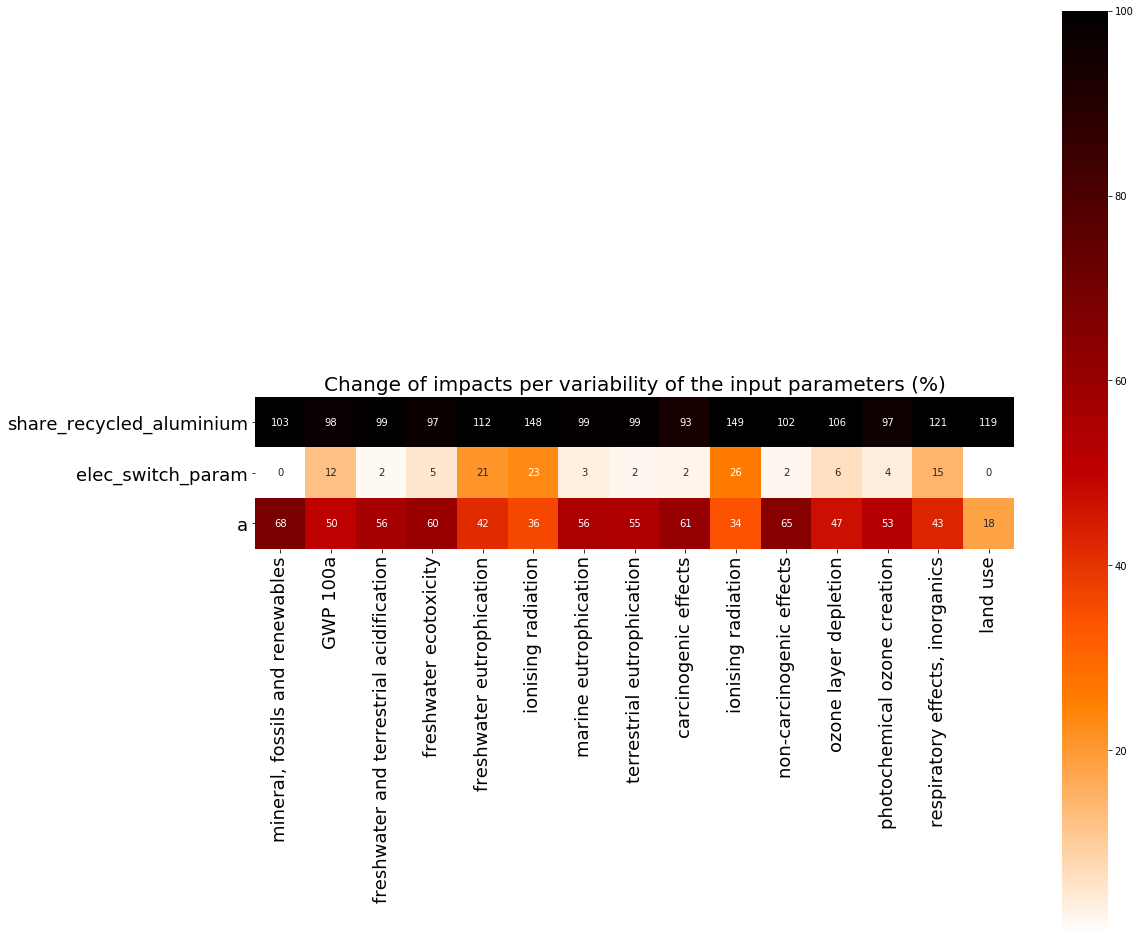

In [74]:
oat_matrix(model, impacts)

### oat_dashboard_matrix

This functions draws a dashboard showing :
* A dropdown list, for choosing a parameter
* Several graphs of evolution of impacts for this parameter
* Full table of data
* A graph of "bars" representing the variation of each impact for this parameter (similar to the information given in oat_matrix) 

In [81]:
oat_dashboard_interact(model, impacts)

interactive(children=(Dropdown(description='param', options=('share_recycled_aluminium', 'elec_switch_param', …

## Monte-carlo methods & Sobol indices

Here we leverage fast computation of monte-carlo approches. 

We compute **global sensivity analysis** (GSA).
Not only local ones.


### Sobol Matrix 

Similar to OAT matrix, we compute Sobol indices. they represent the ratio between the variance due to a given parameter and the total variance.

for easier comparison, we translate those relative sobol indices into "deviation / mean" importance :

$$RelativeDeviation = \frac{\sqrt{sobol(param) \times totalVariance(impact))}}{mean(impact)}$$




In [76]:
# Show sobol indices 
incer_stochastic_matrix(model, impacts)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'resources', 'mineral, fossils and renewables')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'climate change', 'GWP 100a')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater and terrestrial acidification')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater ecotoxicity')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'ionising radiation')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'marine eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'terrestrial eutrophication')
Process

interactive(children=(Dropdown(description='mode', options=(('Raw sobol indices (ST)', 'sobol'), ('Deviation (…

### Violin graphs

We provide a dashboard showing **violin graphs** : the exact probabilistic distribution for each impact. Together with medians of the impacts.

Generating samples ...
Transforming samples ...


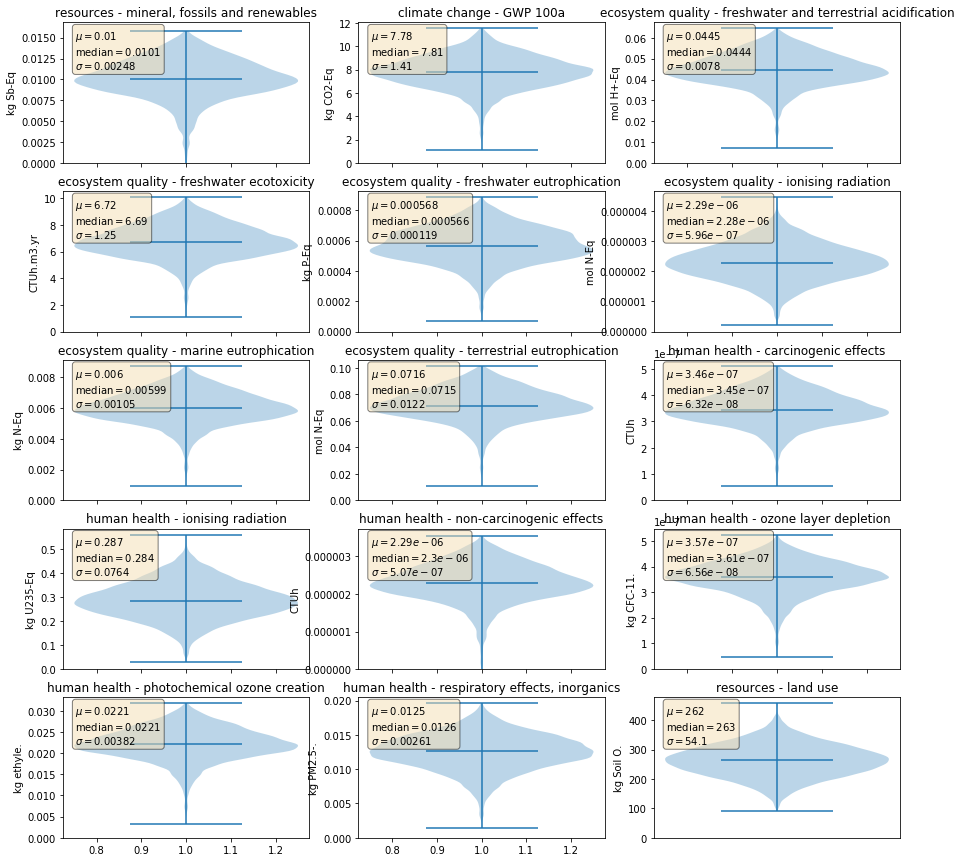

In [77]:
incer_stochastic_violin(model, impacts)

### Full dashboard

A dashboard groups all this information in a single interface with tabs.

It also shows total variation of impacts. This last graph could be improved by showing stacked colored bars with the contribution of each parameter to this variation, according to Sobol indices. 

In [78]:
incer_stochastic_dashboard(model, impacts)

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'resources', 'mineral, fossils and renewables')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'climate change', 'GWP 100a')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater and terrestrial acidification')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater ecotoxicity')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'ionising radiation')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'marine eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'terrestrial eutrophication')
Process

# Producing simplified models 

One of te outcome of the statisticall analysis above would be to identify main input parameters and produce simplidied models, fixing the minor ones.

We provide several functions for doing this.

## Explore initial algrebraic model

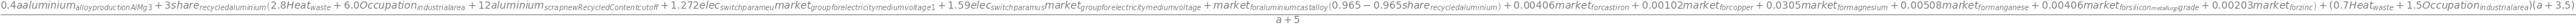

In [89]:
# First, let's look at the full expression defining our model
expr, _ = actToExpression(normalized_model)
expr

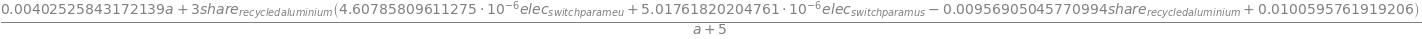

In [99]:
# For each impact, this expression is developped by replacing background activities with their impact value
# Here is an internal method used by #LCAAlgebraic 
lambdas = preMultiLCAAlgebric(normalized_model, impacts)

# "lamddas" wrap the expression together with list of required parameters and a 
# compiled (lambidfy) version of it, ready for fast compuation 

# Here is for example the algebraic expression for the first impact
lambdas[0].expr

## Compute simplified models

We provide some method to automatically select a subset of parameters, based on the **sobol indices**, and then compute simplified models for it.

In [91]:
# We provide some method to automatically select a subset of parameters, 
# based on the sobol indices, and then copute simplified models for it

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'resources', 'mineral, fossils and renewables')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'climate change', 'GWP 100a')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater and terrestrial acidification')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater ecotoxicity')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'ionising radiation')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'marine eutrophication')
Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'terrestrial eutrophication')
Process

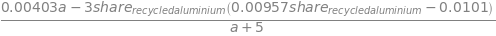

> Method :  climate change - GWP 100a
S1:  0.97516480536627
S2:  0.028089644094584226
ST:  1.0223179376253744
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.842557108710918


> Method :  ecosystem quality - freshwater and terrestrial acidification
S1:  0.9957635420594732
S2:  -0.00041714417215432285
ST:  1.002883415187572
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.992450654696279


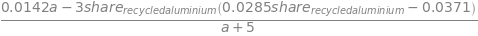

> Method :  ecosystem quality - freshwater ecotoxicity
S1:  0.9936412182030562
S2:  -0.0012138354457286518
ST:  1.0055207617374982
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9623188036408687


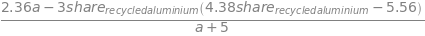

> Method :  ecosystem quality - freshwater eutrophication
S1:  0.9619842543423236
S2:  0.04427450456150728
ST:  1.0373324596675213
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.9323045865393096


> Method :  ecosystem quality - ionising radiation
S1:  0.9738783638374692
S2:  0.0296688294125556
ST:  1.028419906571402
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.9695150317883019


> Method :  ecosystem quality - marine eutrophication
S1:  0.9940289944384164
S2:  0.0032353199287932823
ST:  1.0041298744514193
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9787524555679715


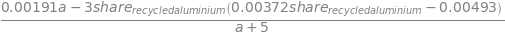

> Method :  ecosystem quality - terrestrial eutrophication
S1:  0.994264644392138
S2:  0.006935027456622344
ST:  1.003518429218772
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9893155261830896


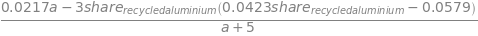

> Method :  human health - carcinogenic effects
S1:  0.9943750685566971
S2:  0.009481375974156764
ST:  1.0031631911272403
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9885233560756967


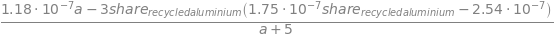

> Method :  human health - ionising radiation
S1:  0.9699778201955064
S2:  0.03340162496814697
ST:  1.032233269620859
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.9675793472282138


> Method :  human health - non-carcinogenic effects
S1:  1.0004749006940485
S2:  -0.02119125593116812
ST:  1.004023720037542
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9982128926486761


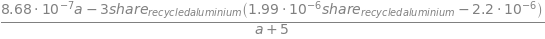

> Method :  human health - ozone layer depletion
S1:  0.9894470281934415
S2:  0.019928296405959542
ST:  1.0092754923580503
Selected params :  ['share_recycled_aluminium'] explains:  0.8819444276839745


> Method :  human health - photochemical ozone creation
S1:  0.9920500157190053
S2:  0.01375431661162187
ST:  1.0052340050547486
Selected params :  ['share_recycled_aluminium'] explains:  0.8073999367697233


> Method :  human health - respiratory effects, inorganics
S1:  0.978941387179046
S2:  0.028118852633208666
ST:  1.0214083288059734
Selected params :  ['share_recycled_aluminium'] explains:  0.8042260836526105


> Method :  resources - land use
S1:  0.9970335510077101
S2:  0.0044202209217904685
ST:  1.0066682177304052
Selected params :  ['share_recycled_aluminium'] explains:  0.9711912612056794


In [105]:
simplified = sobol_simplify_model(
    normalized_model, 
    impacts,
    n=10000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = FixedParamMode.MEDIAN, # We replace minor parameters by median by default
)

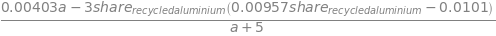

In [106]:
# Let's look at the expression for first impact again 
# much simpler ! 
simplified[0].expr

## Compare simplified model with full model

Finally, we can compare the distribution of those simplified model against the full model. We provide a function for graphical display of it, and compuation of de R-Square score.


Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...
Generating samples ...
Transforming samples ...


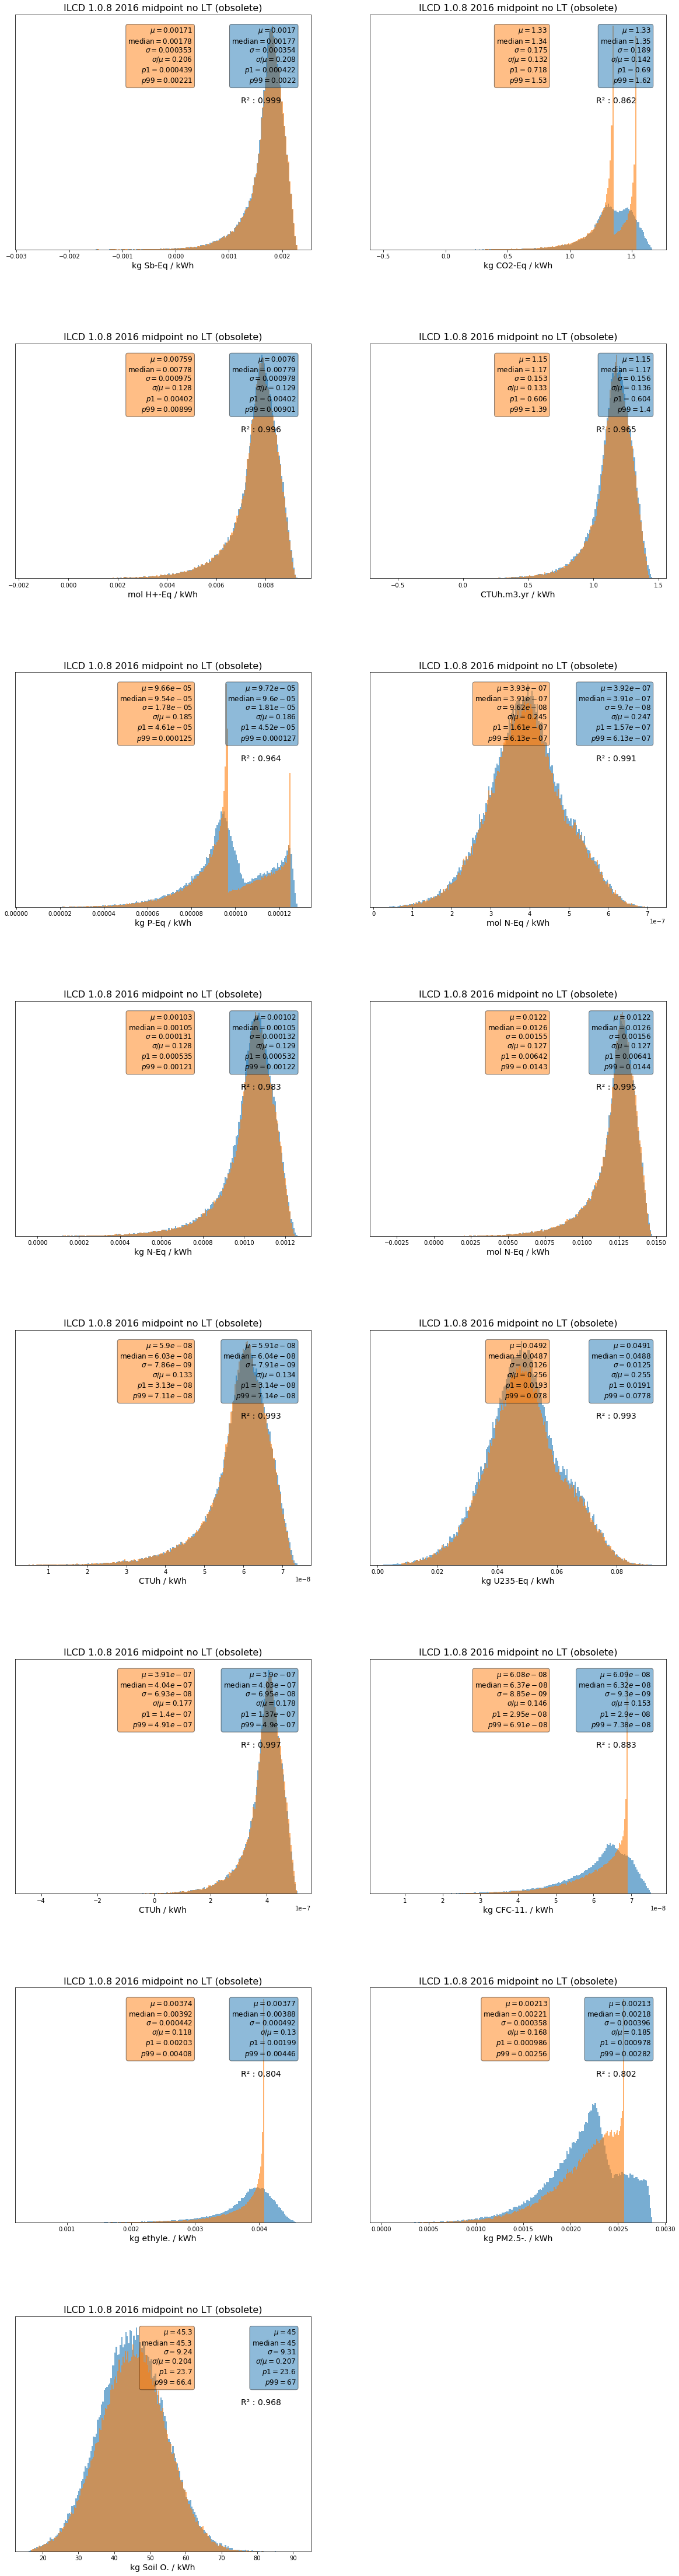

In [111]:
compare_simplified(normalized_model, impacts, simplified)